## Import

In [1]:
import trimesh as tm
import topogenesis as tg
import numpy as np
import matplotlib.pyplot as plt

import os
import math

from skcriteria import Data
from skcriteria.madm.simus import SIMUS
from skcriteria.madm import closeness, simple

## Loading context

In [2]:
path = os.path.relpath('../data/my_envelope.obj') # building outer boundaries file path
buildingplot = tm.load(path) # load specified building boundary mesh (footprint extruded to max height TODO: will be USER INPUT)

## Presets

In [3]:
vox_size = 10
fh = 3.6 # floor height
FSI_req = 4 # goal for the FSI TODO: USER INPUT

max_extents_height = abs(buildingplot.bounds[0][2]) + abs(buildingplot.bounds[1][2])
max_extents_width = abs(buildingplot.bounds[0][0]) + abs(buildingplot.bounds[1][0])
max_extents_length = abs(buildingplot.bounds[0][1]) + abs(buildingplot.bounds[1][1])

base = buildingplot.apply_transform(tm.transformations.projection_matrix((0,0,0), (0,0,-1))) # project mesh on z plane to get footprint <-- TODO: easier way?
plot_area = base.area/2 # area calculates both sides of the flattened mesh, we need only 1

# Annual solar energy output of PV is calculated as follows:
# E(kwh) = A*r*H*PR where A = total solar panel area, r = solar panel yield/efficiency, H = Annual average solar radiation, PR = performance ratio
# from this site TODO find better source: https://photovoltaic-software.com/principle-ressources/how-calculate-solar-energy-power-pv-systems 

r = 0.15 # yield/efficiency estimate
H = 1050 # to be updated, currently wikipedia estimate. kWh.y
PR = 0.75 # default value, estimate performance ratio influenced by shading, temperature, dust etc.
PV_req = 20 # kWh/m2/year TODO: change to actual expected value from included colors + find source on this value

## Objective functions

In [4]:
def FSI_lowres(floors, width, length, plot = plot_area, goal = FSI_req):
    FSI = (floors * width * length) / plot
    FSI_normalized = 1/(1+(FSI - goal)**2)
    if FSI >= goal:
        FSI_normalized = 1 # if FSI is more than needed, normalized value is 1
    return FSI, FSI_normalized # gives a rough estimate of the FSI, and normalizes this value on 0-1 depending on how close to the goal it is. 1 if it exceeds the goal

def PV_lowres(floors, width, length, rotation, goal = PV_req):
    A = width * length
    E = r * H * PR * A
    return PV, PV_normalized

## Matrices of alternatives - cvxopt version

In [5]:
plot_area = 10000
c1 = plot_area # maximum area
c2 = r * H * PR # PV yield per m2 roof
c3 = 200000.0 # PV goal for a year
c4 = 10.0 # floor upper limit
c5 = 1.0 # floor lower limit
c6 = 100.0 # area lower limit
c7 = 10.0 # FSI goal
c8 = 50.0 # PV goal per m2 variable

def FSI_cvxopt(floors, area): # should calculate same score as CVXOPT does with qp
    FSI_score = floors * area * c1**-1 * c7**-1
    return FSI_score

def PV_cvxopt(area): # should calculate same score as CVXOPT does with qp
    PV_score = area * c2 * -c3**-1
    return PV_score

def FSI_real(floors, area): # should calculate the required FSI normalized score
    FSI = (floors * area) / c1
    FSI_normalized = 1/(1+(FSI - c7)**2) # missed brackets??
    return FSI_normalized

def PV_real(floors, area):
    E = r * H * PR * area
    req = c3
    PV_normalized = 1/(1+(E - req)**2)
    return PV_normalized

# -FSI_cvxopt(10, 18000) + PV_cvxopt(18000) # verify if results make sense

lst1 = []
scale = int(c1/1000)

# for i in range(scale):
#     for j in range(int(c4)):
#         proj_list = []
#         FSI_score = FSI_cvxopt(j,i*1000)
#         PV_score = PV_cvxopt(i*1000)
#         proj_list.append(FSI_score)
#         proj_list.append(PV_score)
#         lst1.append([FSI_score, PV_score])
        # score_total = -FSI_score + PV_score
indices1 = []

for floors in range(int(c4)):
    for area in range(scale):
        realfloors = floors+1
        realarea = area+1
        proj_list = []
        FSI_score = FSI_cvxopt(realfloors,realarea*1000)
        PV_score = PV_cvxopt(realarea*1000)
        proj_list.append(FSI_score)
        proj_list.append(PV_score)
        lst1.append([FSI_score, PV_score])
        indices1.append([realfloors, realarea*1000])

[[1, 1000],
 [1, 2000],
 [1, 3000],
 [1, 4000],
 [1, 5000],
 [1, 6000],
 [1, 7000],
 [1, 8000],
 [1, 9000],
 [1, 10000],
 [2, 1000],
 [2, 2000],
 [2, 3000],
 [2, 4000],
 [2, 5000],
 [2, 6000],
 [2, 7000],
 [2, 8000],
 [2, 9000],
 [2, 10000],
 [3, 1000],
 [3, 2000],
 [3, 3000],
 [3, 4000],
 [3, 5000],
 [3, 6000],
 [3, 7000],
 [3, 8000],
 [3, 9000],
 [3, 10000],
 [4, 1000],
 [4, 2000],
 [4, 3000],
 [4, 4000],
 [4, 5000],
 [4, 6000],
 [4, 7000],
 [4, 8000],
 [4, 9000],
 [4, 10000],
 [5, 1000],
 [5, 2000],
 [5, 3000],
 [5, 4000],
 [5, 5000],
 [5, 6000],
 [5, 7000],
 [5, 8000],
 [5, 9000],
 [5, 10000],
 [6, 1000],
 [6, 2000],
 [6, 3000],
 [6, 4000],
 [6, 5000],
 [6, 6000],
 [6, 7000],
 [6, 8000],
 [6, 9000],
 [6, 10000],
 [7, 1000],
 [7, 2000],
 [7, 3000],
 [7, 4000],
 [7, 5000],
 [7, 6000],
 [7, 7000],
 [7, 8000],
 [7, 9000],
 [7, 10000],
 [8, 1000],
 [8, 2000],
 [8, 3000],
 [8, 4000],
 [8, 5000],
 [8, 6000],
 [8, 7000],
 [8, 8000],
 [8, 9000],
 [8, 10000],
 [9, 1000],
 [9, 2000],
 [9, 300

In [6]:
PV_cvxopt(10000), FSI_cvxopt(10, 10000)

(-5.906250000000001, 1.0)

In [7]:
data = Data(
    # alternative matrix
    mtx=lst1,
    
    # optimal sense
    criteria=[max, max],

    # names of alternatives and criteria
    anames=list(id for id, val in enumerate(lst1)),
    cnames=["FSI", "PV"]
)

<module 'matplotlib.pyplot' from 'C:\\Users\\maxke\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\pyplot.py'>

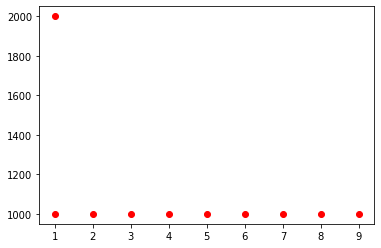

In [8]:
dm = simple.WeightedSum()
dec = dm.decide(data)

arr = np.array(dec.rank_)
new = np.argsort(arr)[-10:]
myplotlist = [indices1[i] for i in new]

lala = np.array(myplotlist)
lulu = lala.transpose()

x = lulu[0]
y = lulu[1]

plt.plot(x, y, 'o', color='red');
plt

In [9]:
lst2 = []
scale = int(c1/1000)
indices2 = []
# for i in range(scale):
#     for j in range(int(c4)):
#         proj_list = []
#         FSI_score = FSI_real(j,i*1000)
#         PV_score = PV_real(j,i*1000)
#         proj_list.append(FSI_score)
#         proj_list.append(PV_score)
#         lst2.append([FSI_score, PV_score])

for floors in range(int(c4)):
    for area in range(scale):
        realfloors = floors+1
        realarea = area+1
        proj_list = []
        FSI_score = FSI_real(realfloors,realarea*1000)
        PV_score = PV_real(realfloors,realarea*1000)
        proj_list.append(FSI_score)
        proj_list.append(PV_score)
        lst2.append([FSI_score, PV_score])
        indices2.append([realfloors, realarea*1000])

In [10]:
data2 = Data(
    # alternative matrix
    mtx=lst2,
    
    # optimal sense
    criteria=[max, max],

    # names of alternatives and criteria
    anames=list(id for id, val in enumerate(lst1)),
    cnames=["FSI", "PV"]
)

In [11]:
dm = simple.WeightedSum()
dec = dm.decide(data2)


In [12]:
arr = np.array(dec.rank_)
new = np.argsort(arr)[-10:]
myplotlist = [indices1[i] for i in new]


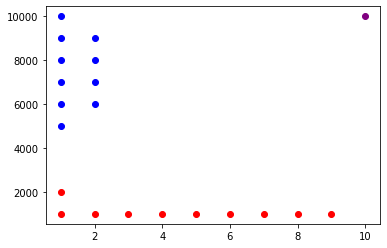

In [13]:
lila = np.array(myplotlist)
lilu = lila.transpose()

x2 = lilu[0]
y2 = lilu[1]

plt.plot(x2, y2, 'o', color='blue')
plt.plot(x, y, 'o', color='red')
plt.plot(10, 10000, 'o', color='purple')

In [14]:
import trimesh as tm
import copy
import pyvista as pv

l = np.sqrt(10000)
w = l
h = 10*3.6

box1 = tm.creation.box((l,w,h))

matrix = tm.transformations.translation_matrix((0,150,0))
trans = tm.transformations.translation_from_matrix(matrix)
box1.apply_translation(trans)

l = np.sqrt(6000)
w = l
h = 2*3.6

box2 = tm.creation.box((l,w,h))

matrix2 = tm.transformations.translation_matrix((150,0,0))
trans2 = tm.transformations.translation_from_matrix(matrix2)
box2.apply_translation(trans2)

l = np.sqrt(1000)
w = l
h = 9*3.6

box3 = tm.creation.box((l,w,h))

context_path = os.path.relpath('../data/immediate_context.obj')
context = tm.load(context_path)

# convert to trimesh definition, taken from spatial computing workshop
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh 

# Visualize the mesh using pyvista plotter

# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the base mesh: light blue
p.add_mesh(tri_to_pv(box1), color='#800080')
p.add_mesh(tri_to_pv(box2), color='#0000A0')
p.add_mesh(tri_to_pv(box3), color='#FF0000')
# p.add_mesh(tri_to_pv(context), color='#abd8ff')

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(448.0601855484773, 459.3303520864031, 378.6952688174402),
 (69.36491673103708, 80.63508326896292, 0.0),
 (0.0, 0.0, 1.0)]